In [128]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from fastprogress import progress_bar
import missingno as msno

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader

# # Set maximum number of rows to display
# pd.set_option('display.max_rows', 15)
# # Display all columns without truncation
# pd.set_option('display.max_columns', None)

# 0. Preprocessing

In [129]:
file_path = os.getcwd()
train_file = '/train.csv'
test_file = '/test.csv'

train_file_path = file_path + train_file
test_file_path = file_path + test_file

In [130]:
df = pd.read_csv(train_file_path)
train = pd.read_csv(train_file_path)
test = pd.read_csv(train_file_path)

# 1. Data
## 1.1 Exploration


In [131]:
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [133]:
df.tail()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1
159255,159255,40,145,45,76.4,1.0,1.2,1,1,125,...,87,81,14.0,1,0.8,21,16,17,0,0


In [134]:
df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [135]:
df.shape

(159256, 24)

In [136]:
#>> Target
df.smoking.value_counts()

smoking
0    89603
1    69653
Name: count, dtype: int64

<Axes: >

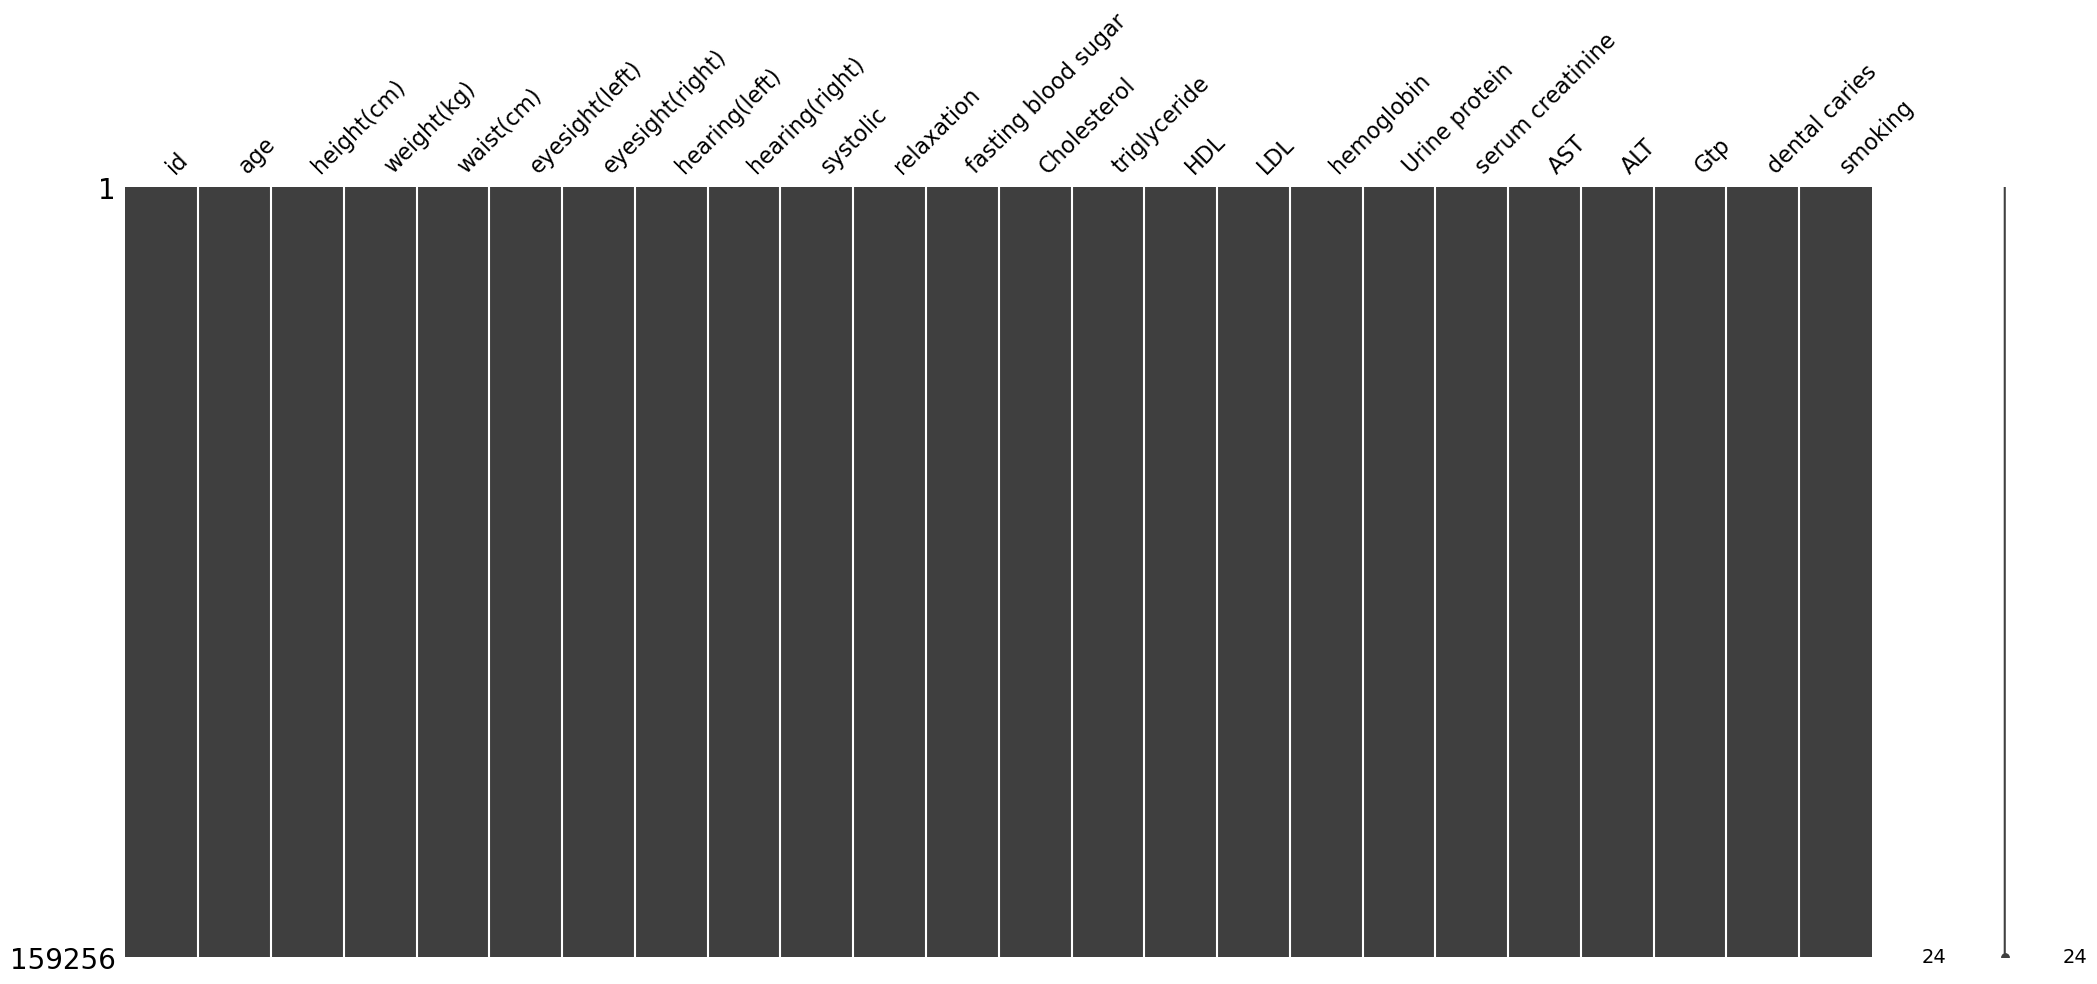

In [137]:
msno.matrix(df)

## 1.2 Processing


In [138]:
df = df.astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  float32
 1   age                  159256 non-null  float32
 2   height(cm)           159256 non-null  float32
 3   weight(kg)           159256 non-null  float32
 4   waist(cm)            159256 non-null  float32
 5   eyesight(left)       159256 non-null  float32
 6   eyesight(right)      159256 non-null  float32
 7   hearing(left)        159256 non-null  float32
 8   hearing(right)       159256 non-null  float32
 9   systolic             159256 non-null  float32
 10  relaxation           159256 non-null  float32
 11  fasting blood sugar  159256 non-null  float32
 12  Cholesterol          159256 non-null  float32
 13  triglyceride         159256 non-null  float32
 14  HDL                  159256 non-null  float32
 15  LDL              

## 1.3 Feature selection

In [139]:
cor = df.corr()["smoking"].abs().sort_values(ascending=False)

cor.head(15)

smoking             1.000000
hemoglobin          0.450679
height(cm)          0.447111
weight(kg)          0.351748
triglyceride        0.331975
Gtp                 0.305561
serum creatinine    0.272979
HDL                 0.271186
waist(cm)           0.262715
age                 0.206033
ALT                 0.163016
eyesight(right)     0.109781
relaxation          0.109501
dental caries       0.106636
eyesight(left)      0.100420
Name: smoking, dtype: float64

In [140]:
cor.tail(15)

age                    0.206033
ALT                    0.163016
eyesight(right)        0.109781
relaxation             0.109501
dental caries          0.106636
eyesight(left)         0.100420
fasting blood sugar    0.096534
LDL                    0.072285
AST                    0.059394
systolic               0.058642
Cholesterol            0.051896
hearing(left)          0.038219
hearing(right)         0.036858
Urine protein          0.028548
id                     0.000632
Name: smoking, dtype: float64

In [141]:
top5 = cor.head(6)
subset = df[top5.index]
subset

,smoking,hemoglobin,height(cm),weight(kg),triglyceride,Gtp
0,1.0,16.500000,165.0,60.0,300.0,27.0
1,0.0,16.200001,165.0,65.0,55.0,37.0
2,1.0,17.400000,170.0,75.0,197.0,53.0
3,0.0,15.900000,180.0,95.0,203.0,30.0
4,1.0,15.400000,165.0,60.0,87.0,17.0
...,...,...,...,...,...,...
159251,0.0,14.500000,155.0,45.0,47.0,13.0
159252,0.0,14.500000,155.0,75.0,202.0,18.0
159253,0.0,10.900000,160.0,50.0,45.0,12.0
159254,1.0,14.400000,165.0,75.0,148.0,37.0


In [142]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   smoking       159256 non-null  float32
 1   hemoglobin    159256 non-null  float32
 2   height(cm)    159256 non-null  float32
 3   weight(kg)    159256 non-null  float32
 4   triglyceride  159256 non-null  float32
 5   Gtp           159256 non-null  float32
dtypes: float32(6)
memory usage: 3.6 MB


/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


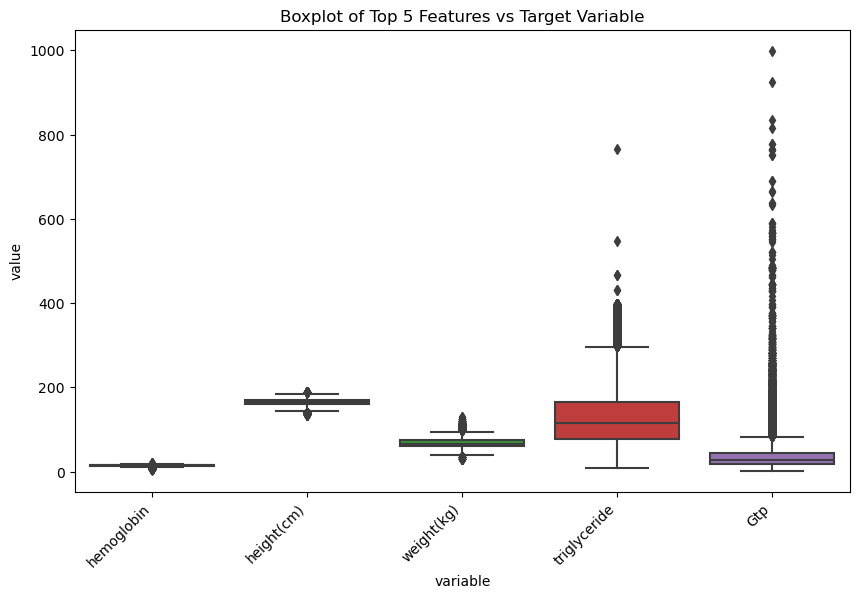

In [191]:
# Melt the DataFrame to long format for boxplot
subset_melted = pd.melt(subset, id_vars='smoking')

# Visualize the relationship with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=subset_melted, x='variable', y='value')
plt.title('Boxplot of Top 5 Features vs Target Variable')
plt.xticks(rotation=45, ha='right')
plt.show()

In [181]:
correlation = df.corr(method = 'pearson')["smoking"].abs().sort_values(ascending=False)
correlation

smoking                1.000000
hemoglobin             0.450679
height(cm)             0.447111
weight(kg)             0.351748
triglyceride           0.331975
Gtp                    0.305561
serum creatinine       0.272979
HDL                    0.271186
waist(cm)              0.262715
age                    0.206033
ALT                    0.163016
eyesight(right)        0.109781
relaxation             0.109501
dental caries          0.106636
eyesight(left)         0.100420
fasting blood sugar    0.096534
LDL                    0.072285
AST                    0.059394
systolic               0.058642
Cholesterol            0.051896
hearing(left)          0.038219
hearing(right)         0.036858
Urine protein          0.028548
id                     0.000632
Name: smoking, dtype: float64

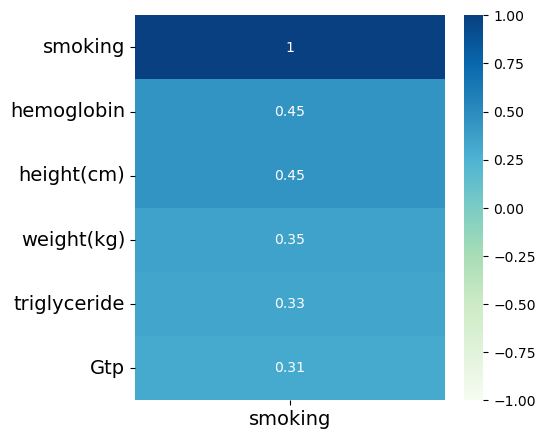

In [189]:
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(df.corr()[['smoking']].abs().sort_values('smoking').tail(6),
            vmax=1, vmin=-1, annot=True, ax=ax, cmap="GnBu");

ax.invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## 1.4 Outliers
Removing outliers is only necessary for the features that are going to be feeded to the model.

In [144]:
# Calculate z-scores
z_scores = np.abs(stats.zscore(subset))

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outlier indices
outlier_indices = np.where(z_scores > threshold)[0]

In [145]:
outlier_indices

array([     5,     16,     36, ..., 159176, 159178, 159212])

In [146]:
cleaned_data = subset.drop(outlier_indices)

In [147]:
cleaned_data

,smoking,hemoglobin,height(cm),weight(kg),triglyceride,Gtp
0,1.0,16.500000,165.0,60.0,300.0,27.0
1,0.0,16.200001,165.0,65.0,55.0,37.0
2,1.0,17.400000,170.0,75.0,197.0,53.0
3,0.0,15.900000,180.0,95.0,203.0,30.0
4,1.0,15.400000,165.0,60.0,87.0,17.0
...,...,...,...,...,...,...
159251,0.0,14.500000,155.0,45.0,47.0,13.0
159252,0.0,14.500000,155.0,75.0,202.0,18.0
159253,0.0,10.900000,160.0,50.0,45.0,12.0
159254,1.0,14.400000,165.0,75.0,148.0,37.0


/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michellehu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


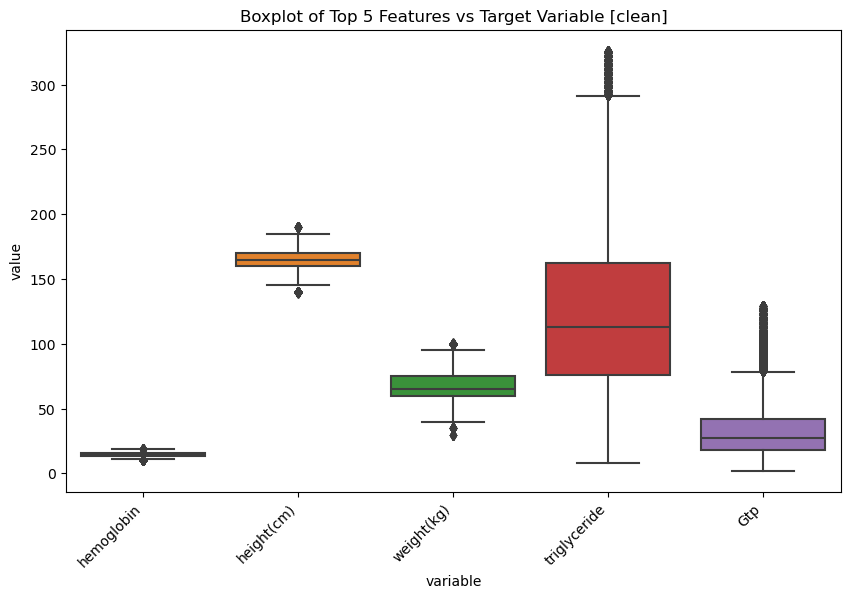

In [190]:
# Melt the DataFrame to long format for boxplot
clean_melt = pd.melt(cleaned_data, id_vars='smoking')

# Visualize the relationship with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=clean_melt, x='variable', y='value')
plt.title('Boxplot of Top 5 Features vs Target Variable [clean]')
plt.xticks(rotation=45, ha='right')
plt.show()

In [149]:
df_train = cleaned_data

<Axes: >

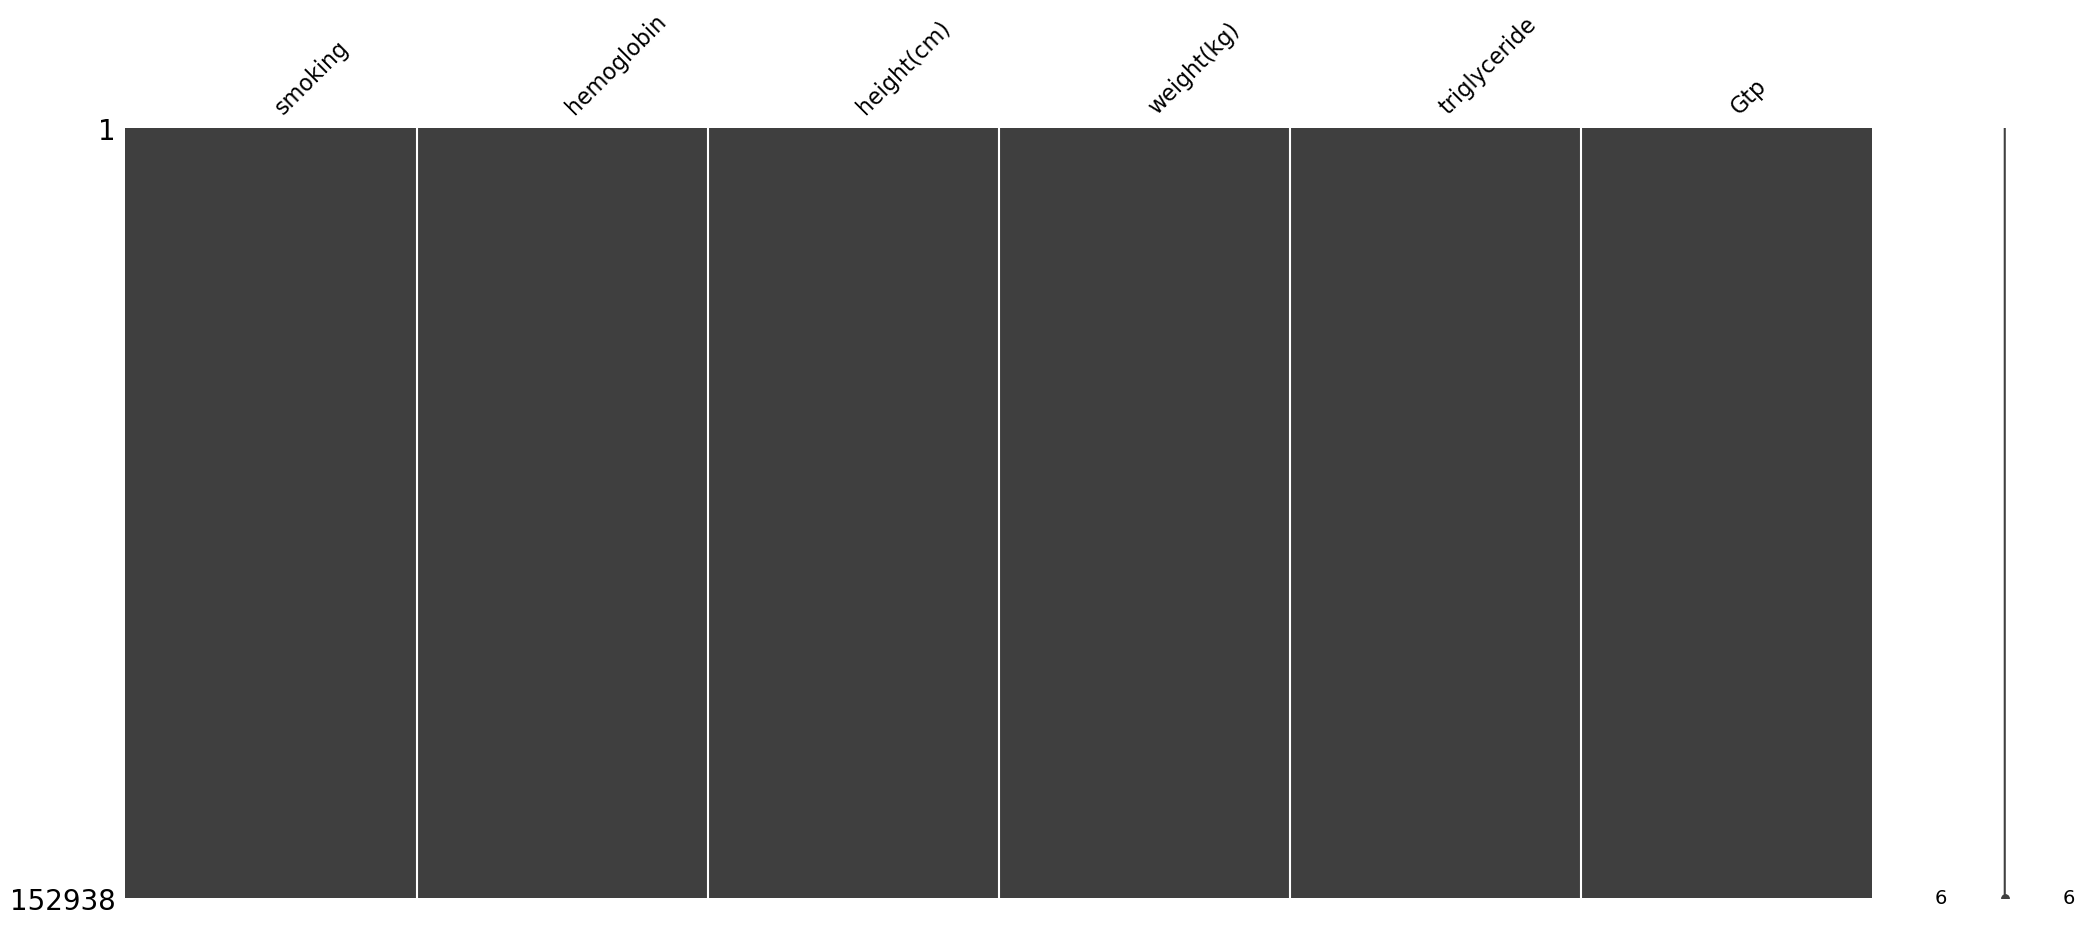

In [150]:
msno.matrix(df_train)

# 2. Train/validation split

In [151]:
array_X = df_train.drop(columns='smoking').to_numpy()
array_y = df_train["smoking"].to_numpy()
array_y = np.reshape(array_y, (-1, 1))

train_X, valid_X, train_y, valid_y = train_test_split(array_X, array_y, test_size=0.2)

## 2.1 Scaling


In [152]:
# Step 1: Instantiate the Scaler (using MinMaxScaler with range (0, 1))
scaler_X = MinMaxScaler(feature_range=(0, 1))

# Step 2: Fit and Transform Training Data
train_X = scaler_X.fit_transform(train_X)

# Step 3: Transform Validation Data
valid_X = scaler_X.transform(valid_X)

In [154]:
# tx = pd.DataFrame(train_X)
# ty = pd.DataFrame(train_y)
# vx = pd.DataFrame(valid_X)
# vy = pd.DataFrame(valid_y)

In [155]:
# csv_file_path1 = "trainX.csv"
# csv_file_path2 = "trainy.csv"
# csv_file_path3 = "validX.csv"
# csv_file_path4 = "validy.csv"

# tx.to_csv(csv_file_path1, index=False)
# ty.to_csv(csv_file_path2, index=False)
# vx.to_csv(csv_file_path3, index=False)
# vy.to_csv(csv_file_path4, index=False)


## 2.2 Tensors


In [156]:
tX = torch.tensor(train_X)
tX  

tensor([[0.6071, 0.5098, 0.6338, 0.6604, 0.5159],
        [0.4048, 0.8039, 0.5634, 0.5943, 0.3730],
        [0.5357, 0.6078, 0.5634, 0.4371, 0.2143],
        ...,
        [0.4167, 0.2157, 0.3521, 0.2956, 0.1270],
        [0.2619, 0.6078, 0.4225, 0.1258, 0.1111],
        [0.7500, 0.5098, 0.6338, 0.4654, 0.7143]])

In [157]:
tX.sum(axis=1)

tensor([2.9270, 2.7394, 2.3583,  ..., 1.4070, 1.5292, 3.0733])

In [158]:
train_ds = TensorDataset(torch.tensor(train_X), torch.tensor(train_y))
valid_ds = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_y))

## 2.3 Data loader

In [159]:
train_dl = DataLoader(train_ds, batch_size=32)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds))

# 3. Model


In [160]:
train_y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [161]:
train_X.shape

(122350, 5)

In [162]:
class Smoke(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Smoke, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = torch.sigmoid(self.output(x))  # Apply sigmoid to final output
        return x


# 4. Trainer


In [176]:
class Trainer:
    def __init__(self, model, lossfunction, train_dl, valid_dl, lr, wd, optimizer=AdamW, metric=None, device=None):
        self.device = device           # Onthoudt het device
        self.model = model.to(device)  # Zet het model op de GPU (of op een ander device)
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.lossfunction = lossfunction
        self.optimizer = optimizer(model.parameters(), lr = lr, weight_decay = wd) # learning rate en weight decay meegeven
        self.metric = metric  
        
        self.epochid = 0
        
    def train_once(self):
        """
            Enkele epoch trainen
        """
        epochloss = 0
        epochn = 0
        torch.set_grad_enabled(True)            # Vereist voor het trainen om zo de gradients te berekenen
        
        for X, y in self.train_dl:
            X, y = X.to(self.device), y.to(self.device)  # Zet de data over op het device
            self.optimizer.zero_grad()          # De gradients worden op nul gezet
            y_pred = self.model(X)              # Een forward pass wordt uitgevoerd
            l = self.lossfunction(y_pred, y)    # Bereken de loss
            l.backward()                        # Bereken en verzamel de gradients
            self.optimizer.step()               # Update de parameters met behulp van de verzamelde gradiënten en de learning rate 
            
            try:
                self.scheduler.step()
            except: 
                pass
            
            epochloss += l.item() * len(X)      # Bereken de totale loss
            epochn += len(X)                    # Bereken het aantal getrainde items in de epoch  

            try:
                y_pred = self.model.post_forward(y_pred)
            except:
                pass         
        
            try:
                all_y = np.concatenate([all_y, y.cpu()])  # Voeg de y's toe aan de huidige batch
            except:
                all_y = y.cpu()                           # Als er nog geen all_y is, gebruik dan de eerste y
            try:
                all_pred_y = np.concatenate([all_pred_y, y_pred.detach().cpu().numpy()]) 
            except:
                all_pred_y = y_pred.detach().cpu().numpy()   
        m = self.metric(all_y, all_pred_y) #squared = false weergeeft de RMSE 
        return [epochloss / epochn, m]               # Return het gewogen gemiddelde over de training

    def validate_once(self):
        """
            Het valideren op de validatie set 
        """
        epochloss = 0
        epochn = 0
        with torch.set_grad_enabled(False):
            for X, y in self.valid_dl:
                X, y = X.to(self.device), y.to(self.device)  
                y_pred = model(X)                
                l = self.lossfunction(y_pred, y)  
                epochloss += l.item() * len(X)    
                epochn += len(X)                  
                
                try:
                    y_pred = self.model.post_forward(y_pred)
                except:
                    pass 
                
                try:
                    all_y = np.concatenate([all_y, y.cpu()])   
                except:
                    all_y = y.cpu()                           
                try:
                    all_pred_y = np.concatenate([all_pred_y, y_pred.cpu()]) 
                except:
                    all_pred_y = y_pred.cpu()    
        m = self.metric(all_y, all_pred_y)     
        return [epochloss / epochn, m];                 
    
    def train(self, epochs, report_frequency=1):
        """
            Daadwerkelijk trainen en de getrainde waarde per epoch printen
        """
        self.train_losses = []
        self.valid_losses = []
        self.train_m = []
        self.valid_m = []
      
        for e in progress_bar(range(epochs)):
            self.epochid +=1
            train_loss, train_m = self.train_once()
            valid_loss, valid_m = self.validate_once()
            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)
            self.train_m.append(train_m)
            self.valid_m.append(valid_m)

            if (((e+1)%report_frequency) ==0) or e == (epochs-1):
                print(f'{self.epochid} train loss: {train_loss:.4f} valid loss: {valid_loss:.4f} {self.metric.__name__} {valid_m:.4f}')

    def learning_curve(self):
        """
            Het visualiseren van de learning curve
        """
        plt.figure()
        plt.plot(range(len(t.train_losses)), t.train_losses, label='train', color='#0077b3')
        plt.plot(range(len(t.valid_losses)), t.valid_losses, label='valid', color='#cc4100')
        plt.legend()
        plt.ylabel('loss_bce')
        plt.xlabel('epochs');
        
    def validation_curve(self):
        """
            Het visualiseren van de validatie curve
        """
        plt.figure()
        plt.plot(range(len(t.train_m)), t.train_m, label='train', color='#0077b3')
        plt.plot(range(len(t.valid_m)), t.valid_m, label='valid', color='#cc4100')
        plt.legend()
        plt.ylabel(self.metric.__name__)      
        plt.xlabel('epoch');     
    
    def plot_curves(self):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
        ax1.plot(range(len(t.train_losses)), t.train_losses, label='train', color='#0077b3')
        ax1.plot(range(len(t.valid_losses)), t.valid_losses, label='valid', color='#cc4100')
        ax1.legend()
        ax1.set_ylabel('loss_bce')
        ax1.set_xlabel('epochs')
        ax1.set_title('Learning curve');
        
        ax2.plot(range(len(t.train_m)), t.train_m, label='train', color='#0077b3')
        ax2.plot(range(len(t.valid_m)), t.valid_m, label='valid', color='#cc4100')
        ax2.legend()
        ax2.set_ylabel(self.metric.__name__)      
        ax2.set_xlabel('epoch')
        ax2.set_title('Validation curve');

# 5. Train and validate


In [177]:
model = Smoke(input_size = 5, hidden_size = 15, output_size=1)

In [178]:
t = Trainer(model, nn.BCELoss(), train_dl, valid_dl, lr=1e-3, wd=0.0001, metric=roc_auc_score)

In [179]:
%%time
t.train(epochs=100, report_frequency=10)

10 train loss: 0.4828 valid loss: 0.4815 roc_auc_score 0.8344
20 train loss: 0.4816 valid loss: 0.4803 roc_auc_score 0.8356
30 train loss: 0.4811 valid loss: 0.4799 roc_auc_score 0.8359
40 train loss: 0.4809 valid loss: 0.4798 roc_auc_score 0.8361
50 train loss: 0.4807 valid loss: 0.4797 roc_auc_score 0.8361
60 train loss: 0.4806 valid loss: 0.4797 roc_auc_score 0.8361
70 train loss: 0.4805 valid loss: 0.4796 roc_auc_score 0.8362
80 train loss: 0.4804 valid loss: 0.4795 roc_auc_score 0.8362
90 train loss: 0.4804 valid loss: 0.4795 roc_auc_score 0.8362
100 train loss: 0.4803 valid loss: 0.4794 roc_auc_score 0.8363
CPU times: user 2min 30s, sys: 1min 25s, total: 3min 56s
Wall time: 2min 4s


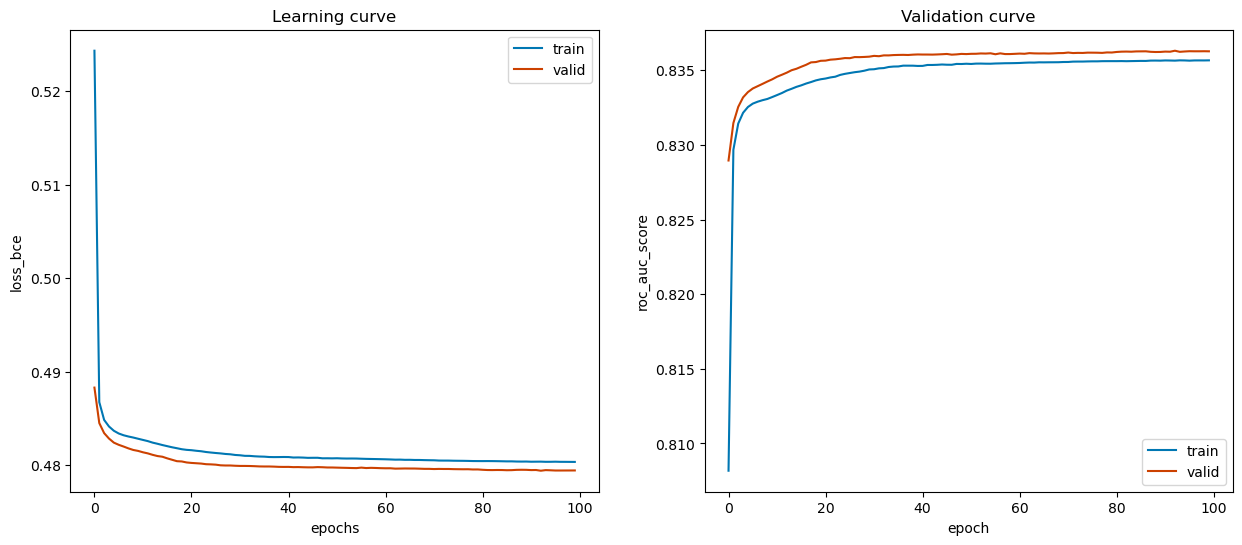

In [180]:
t.plot_curves()

# 6. Predict

In [97]:
model.eval()

Smoke(
  (hidden): Linear(in_features=5, out_features=15, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=15, out_features=1, bias=True)
)

In [117]:
input_data = torch.tensor(train, dtype=torch.float32)

In [113]:
with torch.no_grad():
    output = model(input_data)

In [ ]:
# sigmoid (x) < 0.5 --> class 0
# sigmoid (x) >= 0.5 --> class 1

In [105]:
predictions = (output).float()
predictions

tensor([[0.5806],
        [0.5027],
        [0.6891],
        ...,
        [0.5779],
        [0.2109],
        [0.3683]])

In [123]:
len(predictions)

122350

In [124]:
predictions = pd.DataFrame((output.sigmoid() >= 0.5).float().numpy(), columns=['Predicted_Class'])


In [126]:
df2 = pd.concat([df, predictions], axis=1)


In [127]:
df2

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,Predicted_Class,Predicted_Class
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,16.5,1,1.0,22,25,27,0,1,1.0,1.0
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,16.2,1,1.1,27,23,37,1,0,1.0,1.0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,17.4,1,0.8,27,31,53,0,1,1.0,1.0
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,15.9,1,1.0,20,27,30,1,0,1.0,1.0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,15.4,1,0.8,19,13,17,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,14.5,1,0.8,25,26,13,0,0,NaN,NaN
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,14.5,1,0.6,21,20,18,0,0,NaN,NaN
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,10.9,1,0.6,15,9,12,0,0,NaN,NaN
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,14.4,1,1.1,22,17,37,0,1,NaN,NaN
